<div align="center">
<h1>Loop Q Prize</h1>
<h2 >Challenge A</h2>
    <h3>Solution by Alexandros P. Pouroullis</h3>
<div>

<h3>Sections</h3>

<font size=3>[Loading the Data](#loading-the-data)</font>

<font size=3>[Corpora](#corpora)</font>

<font size=3>[Visualising Audio](#visualising-audio)</font>

<font size=3>[Fourier Transform](#fourier-transform)</font>

<font size=3>[Spectrogram](#spectrogram)</font>

<font size=3>[Mel-Spectrogram](#mel-spectrogram)</font>

<font size=3>[Data Preparation](#data-preparation)</font>

<font size=3>[Pre-Processing](#pre-processing)</font>

<font size=3>[Mel-Frequency Cepstral Coefficients (MFCCs)](#mfcc)</font>

<a id="loading-the-data"></a>
<h1>Loading the Data</h1>

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import wavfile
import os
import pandas as pd
import numpy as np
import IPython.display as ipd
import librosa
import librosa.display
import glob
from IPython.display import Audio
import random

from sklearn.preprocessing import LabelEncoder

In [204]:
train_audio_path = "./challengeA_data/train"
train_csv_path = "./challengeA_data/2022challengeA_train.csv"
test_audio_path = "./challengeA_data/test"
test_csv_path = "./challengeA_data/2022challengeA_test.csv"

In [551]:
train_df = pd.read_csv(train_csv_path, index_col=[0])
test_df = pd.read_csv(test_csv_path, index_col=[0])

train_df.head()

file_id  emotion origin
0  ae2e1c07-4ad7-4bc5-bdac-d3dcf0c8673b.wav     fear  crema
1  08c8ea7c-7f81-41fb-8dfa-eaff9d3c292b.wav     fear  crema
2  f28d06ce-1929-40c4-8c40-7a7671d8c0ab.wav  sadness  crema
3  8934caea-8409-4034-ae41-fa8552e2c3d6.wav  disgust  crema
4  d53575a9-dd20-45c8-a45f-a08e2ad93b9e.wav  neutral  crema

In [488]:
test_df.head()

file_id origin  predicted_emotion
0  030472df-9d70-4d76-a1a5-acb4c33537d3.wav  crema                NaN
1  ac4720de-e0d9-4667-86a7-4236d410ed25.wav  crema                NaN
2  264928af-cb15-4125-abf7-9408369d83b2.wav  crema                NaN
3  2233ce2b-35ae-483c-9397-1058f681b6ef.wav  crema                NaN
4  472aa1eb-b4dc-452c-84b7-934ed61285da.wav  crema                NaN

<a id="corpora"></a>
<h1>Corpora</h1>

For the following section, I load up a csv file modeled off of the first, but cleaned and containing extra metadata that I extracted. I cover the process step by step in the [data preparation](#data-preparation) section.

In [606]:
train_df = pd.read_csv("./challengeA_data/2022challengeA_train_modified.csv", index_col=[0])

The first thing that interests me is the context of the audio recordings in each of the databases. Were the emotions brought about spontaneously, elicited, or acted out? This is an important aspect to consider, because the model would ultimately be applied to contexts wherein users are likely coveying emotions naturally. According to [Li et al. (2015)](https://www.researchgate.net/publication/308841243_From_simulated_speech_to_natural_speech_what_are_the_robust_features_for_emotion_recognition), accuracies of models fell when the corpora changed from simulated to natural. This is, of course, to be expected, because in reality emotion conveyance is far more subtle than when acted out. Furthermore, the type of features extracted can perform differently depending on the corpus that they're being tested on; prosody and voice are found to be robust features for corpora containing simulated emotions, while spectral features are robust for natural and elicited emotions.<br>
<br>
Below, I preview 3 random audio samples from each of the four databases.

In [598]:
sample_size = 4
i = 0 # i is used to determine whether to print a separator
for row in train_df.groupby("origin").apply(lambda x : x.sample(sample_size)).iterrows():
    # the below chunk of code is just used to print a separator every sample_size rows
    if i % sample_size == 0:
        if i != 0:
            print("-"*40)
        i = 0
        
    audio_file_path = os.path.join(train_audio_path, row[1]["file_id"])
    
    if i == 0: print("Origin:", row[1]["origin"])

    try:
        audio_file, sr = librosa.load(audio_file_path, sr=None)
        print("\tEmotion:", row[1]["emotion"])
        display(Audio(audio_file, rate=sr))
    except FileNotFoundError:
        print(f"\tAudio file {audio_file_path} not available.")
        
    i += 1
    
        


Origin: crema
	Emotion: disgust


	Emotion: angry


	Emotion: disgust


	Emotion: sadness


----------------------------------------
Origin: ravdess
	Emotion: neutral


	Emotion: angry


	Emotion: angry


	Emotion: angry


----------------------------------------
Origin: savee
	Emotion: surprise


	Emotion: angry


	Emotion: surprise


	Emotion: disgust


----------------------------------------
Origin: tess
	Emotion: happy


	Emotion: disgust


	Emotion: sadness


	Emotion: angry


A couple of factors can be discerned: all the emotions appear to be simulated, there are both male and female actors present, accents vary between databases, and the sound quality between databases also differs. These latter three aspects may help the model generalize better.

I now get the number of clips from each corpus.

In [608]:
train_df.groupby("origin")["origin"].count()

origin
crema      6306
ravdess    1041
savee       397
tess       2366
Name: origin, dtype: int64

In [611]:
train_df.groupby("origin")["sample_rate"].unique()

origin
crema      [16000.0]
ravdess    [48000.0]
savee      [44100.0]
tess       [24414.0]
Name: sample_rate, dtype: object

<h3 align="center">Summary of Corpora</h3>
<table style="border:1px solid black">
    <thead>
        <tr>
            <th></th>
            <th scope="col">Number of clips</th>
            <th scope="col">Simulated?</th>
            <th scope="col">Sample rate</th>
            <th scope="col">Gender balanced?</th>
            <th scope="col">Accents (Homo-/Hetereogeneous)</th>
        </tr>
    </thead>
    <tbody>
    <tr>
        <th scope="row">CREMA</th>
        <td align="center">6306</td>
        <td>Yes</td>
        <td>16kHz</td>
        <td>Yes</td>
        <td>Heteregeneous</td>
    </tr>
    <tr>
        <th scope="row">RAVDESS</th>
        <td>1041</td>
        <td>Yes</td>
        <td>48kHz</td>
        <td>Yes</td>
        <td>Homogeneous</td>
    </tr>
    <tr>
        <th scope="row">SAVEE</th>
        <td>397</td>
        <td>Yes</td>
        <td>44.1kHz</td>
        <td>No</td>
        <td>Homogeneous</td>
    </tr>
    <tr>
        <th scope="row">TESS</th>
        <td>2366</td>
        <td>Yes</td>
        <td>24.414kHz</td>
        <td>No</td>
        <td>Homogeneous</td>
    </tr>
    </tbody>
</table>

<a id="visualising-audio"></a>
<h1>Visualising Audio</h1>

In [619]:
# Play a 'random' audio file
random_instance = train_df.iloc[7970]
random_audio_file = os.path.join(train_audio_path,random_instance["file_id"])
emotion = random_instance["emotion"]
print("Emotion:", emotion)
Audio(random_audio_file)

Emotion: angry


There are a variety of ways to visualize audio. The simplest is plotting amplitude against time, which I do below.

Sample rate: 24414hz
5 random samples: -0.0093688965, -0.011474609, -0.076812744, -0.1109314, 0.018035889
Audio file duration: 2.32s
Emotion: angry


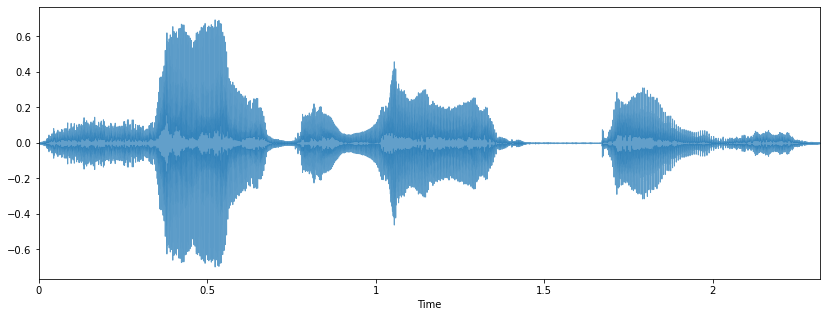

In [620]:
plt.figure(figsize=(14, 5))
samples, sample_rate = librosa.load(random_audio_file, sr=None)   
duration_of_file = len(samples)/sample_rate

print(f"Sample rate: {sample_rate}hz")
print("5 random samples:", ', '.join([str(choice) for choice in random.choices(samples, k=5)]))
print("Audio file duration: {0:.2f}s".format(duration_of_file))
print(f"Emotion: {emotion}")

plt.xlim([0, duration_of_file])
librosa.display.waveshow(samples, sr=sample_rate, alpha=0.7);

Audio is stored on a computer as a discrete time series of amplitudes, called samples. The sample rate represents how many samples are captured per second. Each sample stores only an amplitude – there's no indication of time; the specific time of a sample can be computed by using the index of the sample and multiplying it by the period of a sample which is the inverse of the sample rate (<font size=3>$\frac{1}{sample\ rate}$</font>). 

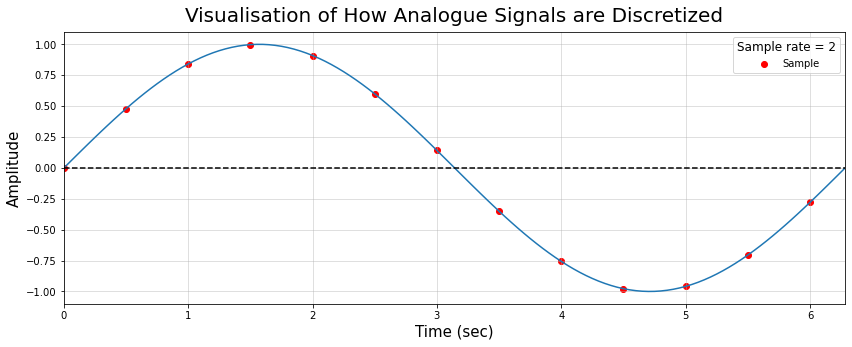

In [653]:
# Plotting a sine wave with samples superimposed on it.
def plot_sin_wave(A=1, freq=1, phase=0, num_cycles=1):
    STEP_SIZE = 0.05
    start = 0 + phase
    period = (2*np.pi)/freq
    stop = num_cycles*period
    
    x = np.arange(start, stop+STEP_SIZE, STEP_SIZE)
    y = A*np.sin(freq*x + phase)
    
    plt.plot(x, y)
    plt.axhline(y=0, color="k", ls='--')
    plt.grid(True, which="both", alpha=0.5)
    plt.xlim([0, stop])


def plot_samples(start, stop, sample_rate):
    sample_period = 1/sample_rate
    x = np.arange(start, stop+sample_period, sample_period)
    y = np.sin(freq*x)
    plt.scatter(x, y, color="r", label=f"Sample")
    plt.legend(title=f"Sample rate = {sample_rate}").get_title().set_fontsize(12)


A = 1
freq = 1
phase = 0
num_cycles = 1
period = (2*np.pi)/freq
start = 0 + phase
stop = num_cycles*period
sample_rate = 2

plt.figure(figsize=(14, 5))
plot_sin_wave(A=A, freq=freq, phase=phase, num_cycles=num_cycles) 
plot_samples(start, stop, sample_rate)
plt.xlabel("Time (sec)", fontsize=15)
plt.ylabel("Amplitude", fontsize=15)
plt.title("Visualisation of How Analogue Signals are Discretized", pad=10, fontsize=20);

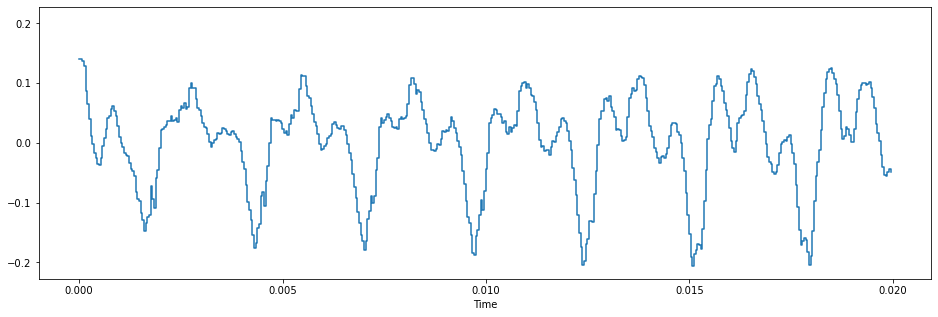

In [621]:
# Zooming into the audio file, displaying 500 random consecutive samples.
sample_start = 20000
duration_in_sec = 0.02
duration_in_samples = int(duration_in_sec*sample_rate)
sample_stop = sample_start + duration_in_samples
sample_of_signal = samples[sample_start:sample_stop]
plt.figure(figsize=(16, 5))
librosa.display.waveshow(sample_of_signal, sr=sample_rate);

We can see in above display that the audio file looks like a highly complex waveform. What if we could break it up so that it was instead a sum of periodic functions that are easily definable, like sinusoids? Fortunately we can *(hint: using the discrete Fourier transform)*! The discrete Fourier transform (DFT) transforms a wave from the time domain to the frequency domain, such that the amplitude of each frequency in the DFT is proportional to the **average** presence of the sinusoidal wave of that frequency in the composition of the original wave. The DFT produces a complex number $c=a+bj$, which can be represented as a point on the complex plane with angle $arg(c)$ ($arg(c)=arctan(\frac{b}{a})$) – phase, and magnitude $abs(c)$ ($abs(c)=\sqrt{Re(c)^2+Im(c)^2}$) – amplitude. Because in our case we only care about the magnitude of the frequencies in their contribution to the signal, we only use the magnitude when plotting the Fourier transform.

<a id="fourier-transform"></a>
<h1>Fourier Transform</h1>

In [711]:
def plot_fft(signal, sr, title):
    ft = np.fft.fft(signal)
    magnitude = np.abs(ft)
    
    frequency = np.linspace(0, sr, len(signal))
    
    plt.figure(figsize=(16, 5))
    plt.plot(frequency, magnitude)
    plt.xlabel("Frequency (hz)")
    plt.xticks(np.arange(min(frequency), max(frequency)+1, 250))
    plt.xlim([0, max(frequency)//4])
    plt.title(title)

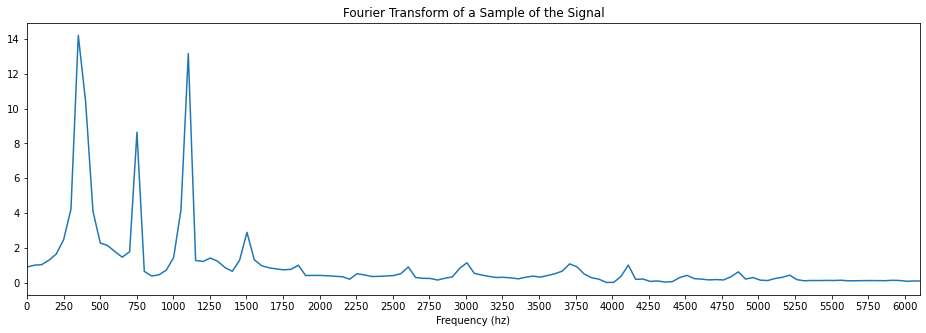

In [623]:
plot_fft(sample_of_signal, sample_rate, "Fourier Transform of a Sample of the Signal")

And *voila*! Our plot also confirms that the frequencies most present in speech are indeed below ~4000hz.

As a fun experiment, I use the data above to create an approximation of the sample of the signal.

In [624]:
def freq_to_angular(freq):
    return (2*np.pi)*freq

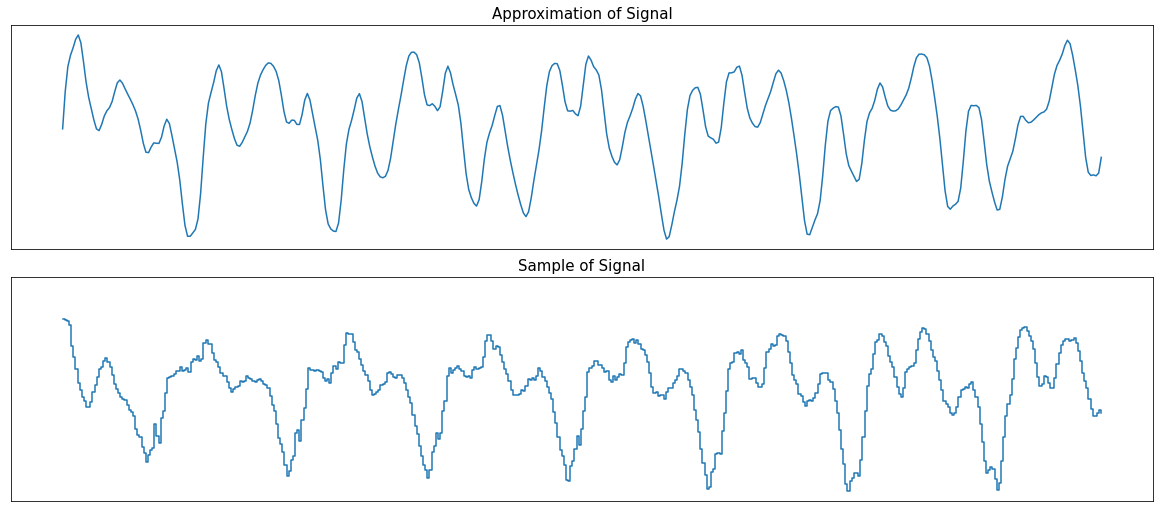

In [625]:
plt.figure(figsize=(16, 7), constrained_layout=True)

time = np.arange(0, duration_in_sec, 0.00005)

phase = 0
# sin 1
omega = freq_to_angular(325)
y1 = 14*np.sin(omega*time + phase)

# sin 2
omega = freq_to_angular(750)
y2 = 8.2*np.sin(omega*time + phase)

# sin 3
omega = freq_to_angular(1100)
y3 = 13.5*np.sin(omega*time + phase)

# sin 4
omega = freq_to_angular(1500)
y4 = 3*np.sin(omega*time + phase)

# sin 5
omega = freq_to_angular(3000)
y5 = np.sin(omega*time + phase)

# sin 6
omega = freq_to_angular(3700)
y6 = np.sin(omega*time + phase)

# sin 7
omega = freq_to_angular(4100)
y7 = np.sin(omega*time + phase)


combined_signal = y1+y2+y3+y4+y5+y6+y7

plt.subplot(2, 1, 1)
plt.title("Approximation of Signal", fontsize=15)
plt.plot(time, combined_signal)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 1, 2)
plt.title("Sample of Signal", fontsize=15)
librosa.display.waveshow(sample_of_signal);
plt.xticks([])
plt.yticks([])
plt.xlabel("");

The only issue with the Fourier transform is that it gives us the frequency components of the signal overall. But we want to know how the frequency content of the sound changes through time. So what do we do? Well, we just compute snapshots of the DFT at regular, short intervals, using what's called the short-time Fourier transform (STFT). The matrix the STFT produces, where rows represent frequency bins (because computers can't compute the magnitude of sinusoid for every $f$ where $f\in\mathbb{R}$) and columns represent uniformly-sized time frames, is called the spectrogram and gives us a very neat, compact representation of the frequency content of a signal through time, thus capturing all the information we set out to gather.

<a id="spectrogram"></a>
<h1>Spectrogram</h1>

In [650]:
samples.shape

(56568,)

In [639]:
# n_fft of 512 is ideal for speech. It must be a power of 2 to improve the speed of the fast fourier transform.
n_fft = 512
hop_length = n_fft // 4
specgram = librosa.stft(samples, n_fft=512, hop_length=hop_length)

# Take only the magnitudes of the frequencies
specgram = np.abs(specgram)

In [627]:
specgram.shape

(257, 442)

The shape of the spectrogram indicates that it captured the magnitudes of 257 frequency bins in 1640 time frames.

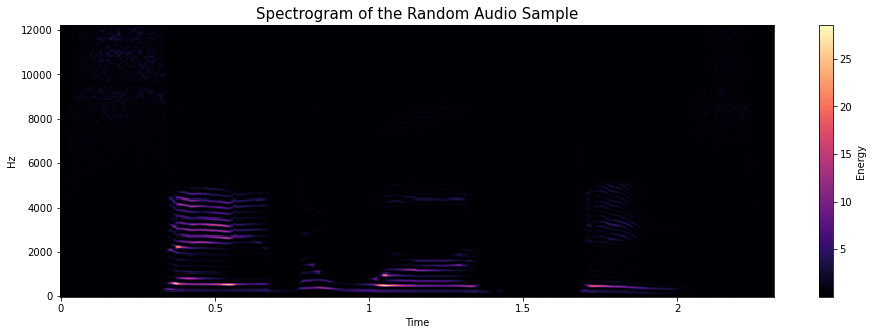

In [640]:
plt.figure(figsize=(16, 5))
# specgram needs to take in the hop length so that it can compute the correct time on the x-axis.
librosa.display.specshow(specgram, sr=sample_rate, x_axis="time", y_axis="linear", hop_length=hop_length);
plt.colorbar().ax.set_ylabel("Energy");
plt.title("Spectrogram of the Random Audio Sample", fontsize=15);

The spectrogram is plotted, but it gives us a rather disappointing result. There is only some indication of energy in the lower frequencies, but it's very faint. <br>
<br>
The reason this is the case is because the range of sound intensities in nature is *extremely* large. And yet we are still able to perceive sounds at two extremes such that they aren't that distant. This is because we perceive sound logarithmically. That's why sound intensity is often converted to the logarithmic scale, measured in decibels (dB), where each increase in 10 decibels represents a sound-energy ten times larger, beginning from some reference point – usually the threshold of hearing.

In [643]:
# Converting the amplitudes/energies to the decibel scale
log_specgram = librosa.amplitude_to_db(specgram, ref=np.max)
log_specgram.shape

(257, 442)

Note that the shape of the *log_specgram* ndarray is the same as the *specgram* ndarray.

Now, let's see what happens when we plot it.

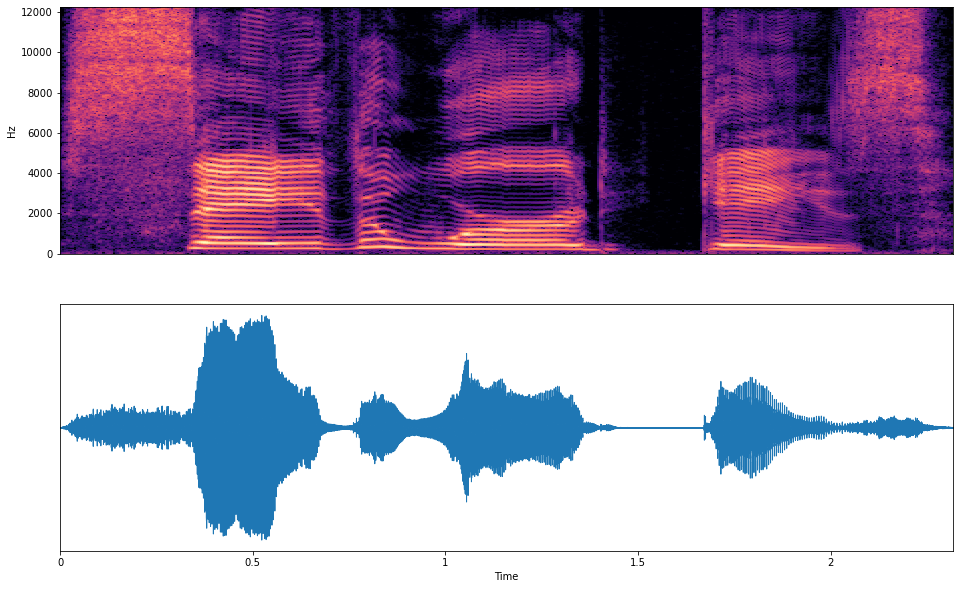

In [644]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
librosa.display.specshow(log_specgram, sr=sample_rate, y_axis="hz", hop_length=hop_length);

plt.subplot(2, 1, 2)
librosa.display.waveshow(samples, sr=sample_rate, x_axis="time");
plt.xlim([0, duration_of_file])
plt.yticks([]);

What's really awesome about the spectrogram is we can visualise where certain sounds occur and how high/low they were. For example, in the first 0.25 seconds, the person in the audio sample uses a hard 's' sound, which can be seen in the upper frequencies at the beginning of the spectrogram.

<a id="mel-spectrogram"></a>
<h1>Mel-Spectrogram</h1>

We've come very far, but there's still one more thing to address. Humans don't perceive sound linearly: differences between lower frequencies are more perceptible than differences between higher frequencies. I'll demonstrate this.

In [228]:
def play_two_sines(freq1, freq2):
    sr = 4.41e4
    duration = 1
    
    time = np.linspace(0, duration, int(sr*duration))
    sound1 = 0.5*np.sin(time*freq_to_angular(freq1))
    sound2 = 0.5*np.sin(time*freq_to_angular(freq2))
    combined_sound = np.concatenate([sound1, sound2])
    
    display(Audio(combined_sound, rate=sr))

In [229]:
# Playing a 100hz sine wave for 2 seconds followed by a 200hz sine wave for 2 seconds
play_two_sines(100, 200)

In [230]:
play_two_sines(1000, 1100)

In [660]:
play_two_sines(18000, 18000)

The 100hz and 200hz sine waves are easy distinguishable; the 1000hz and 1100hz ones to a lesser extent; and the 10000hz and 10100hz barely. And, once again, this should be quite intuitive. Increasing the frequency of a 100hz wave by 100 doubles the frequency, while adding 100hz to 10000hz increases the frequency by only 1%. 

Introducing the mel-scale. The mel-scale is a scale that was determined empirically, such that equal distances on the scale have the same perceptual distance. It provides a linear auditory scale for the human auditory system; frequencies below 1kHz are roughly linearly spaced, and logarithmic above it. The mel-spectrogram will allow us to feed sound information to the model similar to what a human would perceive.<br>
<br>
To convert from frequencies to mels, the below formula is used (the seemingly arbitrary values appear arbitrary because they were, as was stated earlier, determined empirically):<br>
<div align="center">
$f_{mel}=2595log_{10}(1+\frac{f}{700})$
</div>
Where $f$ and $f_{mel}$ denote the actual frequency in Hz and perceived frequency in mels resepectively. 

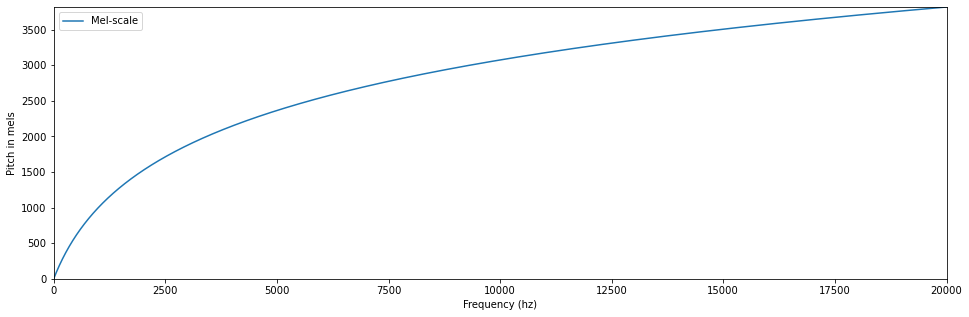

In [232]:
frequencies = np.arange(0, 20000+1, 1)
mel_frequencies = librosa.hz_to_mel(frequencies, htk=True)
plt.figure(figsize=(16, 5))
plt.plot(frequencies, mel_frequencies, label="Mel-scale")
plt.xlabel("Frequency (hz)")
plt.ylabel("Pitch in mels");
plt.xlim([0, np.max(frequencies)])
plt.ylim([0, np.max(mel_frequencies)]);
plt.legend();

As we can see, the mel-scale is logarithmic in shape. This is because pitches with higher frequencies are perceived to be closer together than lower frequencies.

Now, I'll convert the vanilla spectrogram into a mel-spectrogram by applying mel-filter banks onto the spectrogram, which will yield some number $n$ mel-bands which will have magnitudes associated with them, representing how present each band is in that frame of time. What this mel-spectrogram essentially represents is how present bands of frequencies are that are perceptually equal in distance from one another.

In [645]:
mel_specgram = librosa.feature.melspectrogram(y=samples, 
                                                sr=sample_rate, 
                                                n_fft=n_fft,
                                                hop_length=hop_length, 
                                                n_mels=128) 

In [646]:
mel_specgram.shape

(128, 442)

Above, I compute the mel-spectrogram of the audio file. The number of rows represents the number of mel-bins, and the number of columns represents the number of time frames the mel-bins were computed for. <br>
The number of mel-bins selected was arbitrary; there's no one-size fits all amount, so I'll start with the standard 128 bins.

In [647]:
mel_specgram = librosa.power_to_db(mel_specgram)

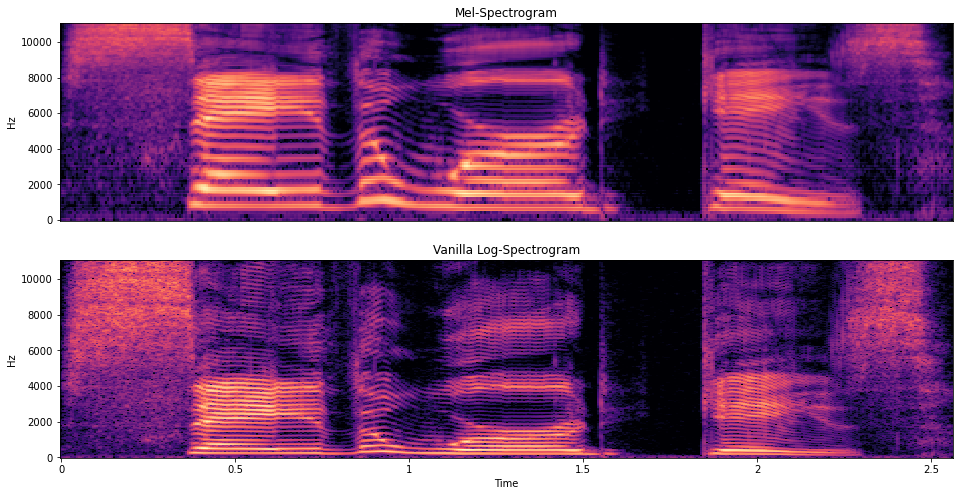

In [649]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.title("Mel-Spectrogram")
librosa.display.specshow(mel_specgram, y_axis="linear", hop_length=hop_length)

plt.subplot(2, 1, 2)
plt.title("Vanilla Log-Spectrogram")
librosa.display.specshow(log_specgram, y_axis="linear", x_axis="time", hop_length=hop_length);

Now that we have a pretty good idea of what features we'll use when training the model, we can move on to preparing the data.

<a id="mfcc"></a>
<h1>Mel-Frequency Cepstral Coefficients (MFCCs)</h1>

MFFCs concisely describe the shape of the spectral envelope of a sound. That might be quite difficult to unpack, but I'll try explain quite basically (well, truth be told, I couldn't do any better because this isn't my domain of expertise anyways) what that would entail for speech.<br>
<br>
The human voice produces sound by passing air through vocals folds at the top of the larynx, which then vibrate at a particular frequency. That frequency is then shaped by the vocal tract to form speech. The peaks of the spectral envelope (smoothed out spectrum) are called formants, which correspond with the acoustic resonance of the vocal tract.
<br><br>
MFCCs are obtained from the mel-frequency cepstrum (amusingly, spectrum with "spec" reversed), where the cepstrum is the inverse-Fourier transform of the log-spectrum of the windowed, signal, which can be found with the following expression:
<div align="center"><font size=3>
$|\mathcal{F}^{-1}\{log(|\mathcal{F\{x(t)\}}|^2)\}|^2$
</font>
</div>
where $\mathcal{F}$ represents the Fourier transform and $\mathcal{F}^{-1}$ its inverse. To obtain the mel-frequency cepstrum, you just take the inverse-Fourier transform of the log of the mel-frequency spectrum.<br>
<br>

It involves a multi-step process: 
  * 1. Window the signal
  * 2. Apply the DFT on the windowed signal to get the power spectrum of the frame
  * 3. Create a mel filter bank and get the weighted sum of each triangular band in the power spectrum
  * 4. Take the logarithm of all the filter band energies
  * 5. Apply the inverse fourier transform on the filter bands to get the mel-frequency cepstrum
  * 6. Take the magnitude of the cepstrum to obtain the mel-frequency cepstral coefficients

Text(0.5, 1.0, 'Mel Cepstrum (First Coefficient Discarded)')

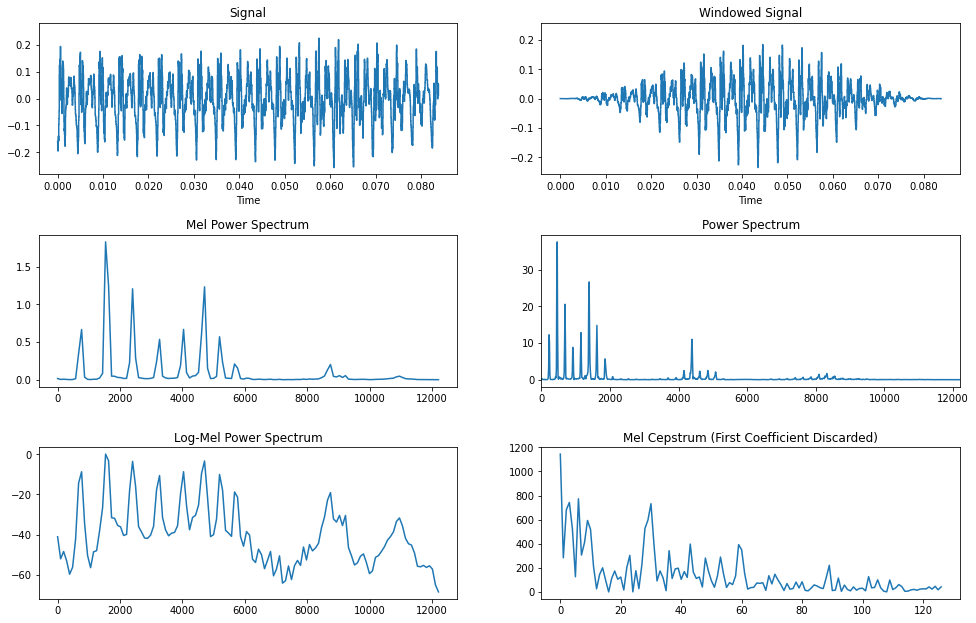

In [904]:
plt.figure(figsize=(16, 10));

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)

# Extracting signal containing n_fft samples
n_fft = 2048
sample_start = 30000
sample_stop = sample_start + n_fft
sample_signal = samples[sample_start: sample_stop]


# Displaying original signal

plt.subplot(3, 2, 1)
librosa.display.waveshow(sample_signal, sr=sr)
plt.title("Signal")

# Windowing

plt.subplot(3, 2, 2)
hann_window = signal.windows.hann(n_fft)
windowed_signal = window * sample_signal
librosa.display.waveshow(windowed_signal, sr=sr);
plt.title("Windowed Signal")

# Power spectrum

plt.subplot(3, 2, 4)
fft = np.fft.fft(windowed_signal)
# discard frequency bins above the Nyquist frequency
fft = fft[:n_fft//2+1]
# Get the magnitude
power_spectrum = np.abs(fft)
plt.title("Power Spectrum")
frequencies = np.linspace(0, sr//2+1, len(power_spectrum))
plt.plot(frequencies, power_spectrum)
plt.xlim([0, sr//2]);

# Mel-frequency power spectrum

plt.subplot(3, 2, 3)
mel_filter_bank = librosa.filters.mel(sr=sr, n_mels=128, n_fft=n_fft)
mel_power_spectrum = np.matmul(mel_filter_bank, power_spectrum)

frequencies = np.linspace(0, sr//2+1, len(mel_power_spectrum))
plt.plot(frequencies, mel_power_spectrum)
plt.title("Mel Power Spectrum");

# Take the log of the mel spectrum

plt.subplot(3, 2, 5)
log_mel_power_spectrum = librosa.amplitude_to_db(mel_power_spectrum, ref=np.max)

plt.plot(frequencies, log_mel_power_spectrum)
plt.title("Log-Mel Power Spectrum");

# Mel-Frequency Cepstrum

plt.subplot(3, 2, 6)
DCT = dct(log_mel_power_spectrum)
mel_cepstrum = np.abs(DCT)

# ift = np.fft.ifft(log_mel_power_spectrum)
# mel_cepstrum = np.abs(ift)
# mel_cepstrum = mel_cepstrum[:128//2+1]

plt.plot(mel_cepstrum[1:])
plt.title("Mel Cepstrum (First Coefficient Discarded)")

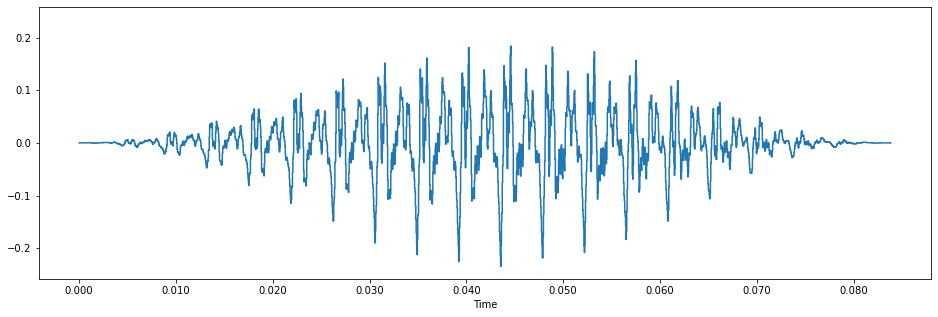

In [811]:
n_fft = 2048
sample_start = 30000
sample_stop = sample_start + n_fft

hann_window = signal.windows.hann(n_fft)
sample_signal = samples[sample_start: sample_stop]
windowed_signal = window * sample_signal

plt.figure(figsize=(16, 5))
librosa.display.waveshow(windowed_signal, sr=sr);

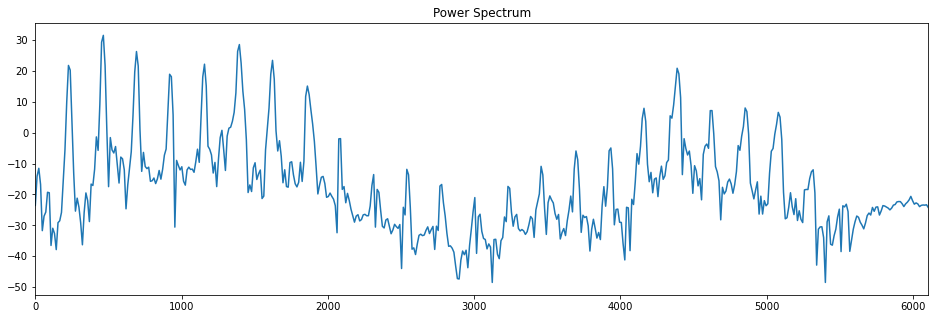

In [897]:
fft = np.fft.fft(windowed_signal)
# discard frequency bins above the Nyquist frequency
fft = fft[:n_fft//2+1]
# Get the magnitude
power_spectrum = np.abs(fft)
log_power_spectrum = librosa.amplitude_to_db(power_spectrum)

plt.figure(figsize=(16, 5))
plt.title("Power Spectrum")
frequencies = np.linspace(0, sr//2+1, len(log_power_spectrum))
plt.plot(frequencies, log_power_spectrum)
plt.xlim([0, sr//4]);

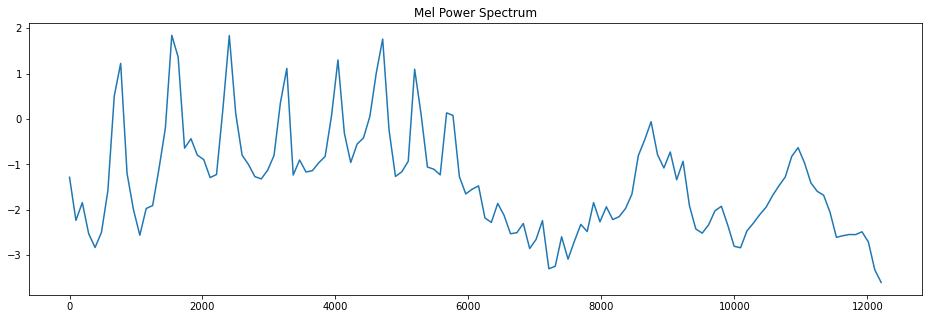

In [898]:
mel_filter_bank = librosa.filters.mel(sr=sr, n_mels=128, n_fft=n_fft)
mel_spectrum = np.matmul(mel_filter_bank, log_power_spectrum)

plt.figure(figsize=(16, 5))
frequencies = np.linspace(0, sr//2+1, len(mel_matrix))
plt.plot(frequencies, mel_spectrum)
plt.title("Mel Power Spectrum");

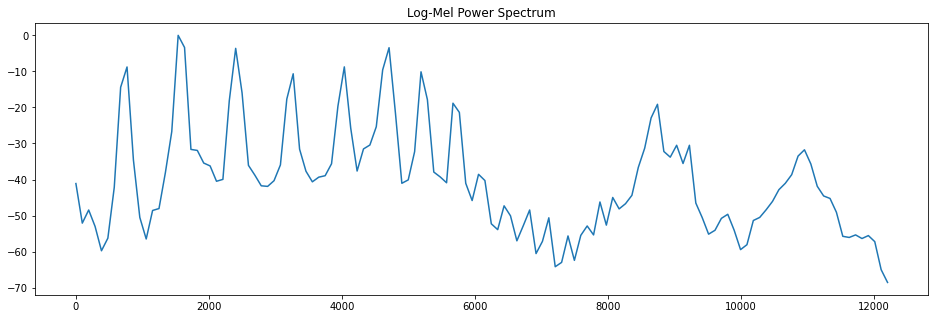

In [856]:
log_mel_power_spectrum = librosa.amplitude_to_db(mel_spectrum, ref=np.max)

plt.figure(figsize=(16, 5))
plt.plot(frequencies, log_mel_power_spectrum)
plt.title("Log-Mel Power Spectrum");

[5.10527053 3.18912733 3.03622209 2.82223848 2.33386036 2.07267719
 1.30018389 0.38903252 0.75613931 0.41727674 0.13818827 1.56768481]
[1143.54038297  284.11998741  682.58282305  742.93779027  524.36854165
  127.08445864  773.15340966  306.93638512  409.36542434  593.53485389
  518.91567169  210.01305979   27.13018069]


Text(0.5, 1.0, 'Mel Cepstrum (First Coefficient Discarded)')

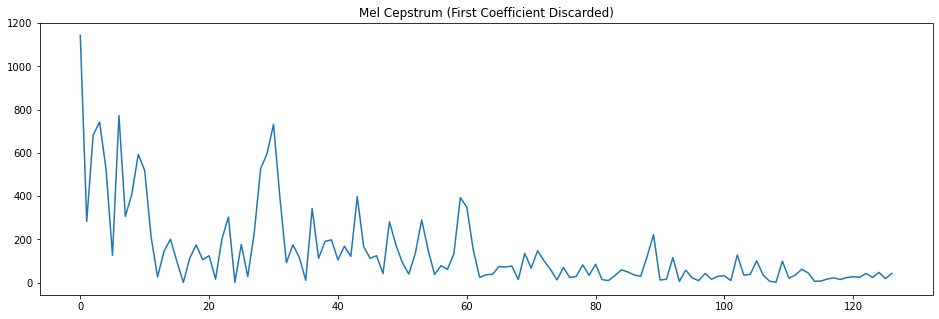

In [884]:
DCT = dct(log_mel_power_spectrum)
DCT = np.abs(DCT)

ift = np.fft.ifft(log_mel_power_spectrum)
mel_cepstrum = np.abs(ift)
# mel_cepstrum = mel_cepstrum[:128//2+1]

plt.figure(figsize=(16, 5))
plt.plot(DCT[1:])
print(mel_cepstrum[1:13])
print(DCT[1:14])
plt.title("Mel Cepstrum (First Coefficient Discarded)")

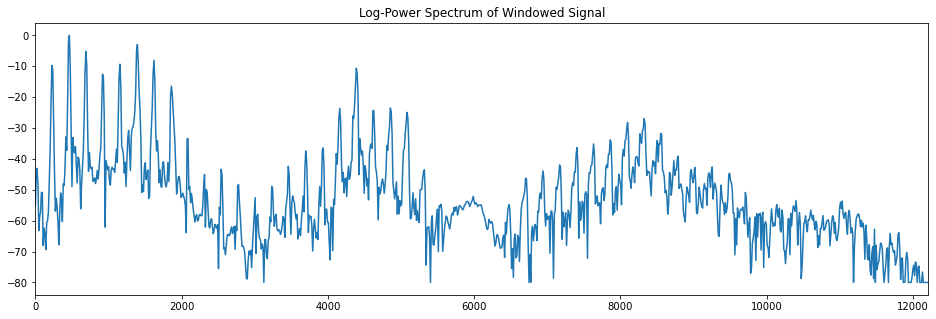

In [741]:
log_power_spectrum = librosa.amplitude_to_db(power_spectrum, ref=np.max)
frequencies = np.linspace(0, sr, len(sample_signal))

plt.figure(figsize=(16, 5))
plt.plot(frequencies, log_power_spectrum)
plt.xlim([0, np.max(frequencies)//2])
plt.title("Log-Power Spectrum of Windowed Signal");

In [746]:
from scipy.fftpack import dct

In [794]:
sr

24414

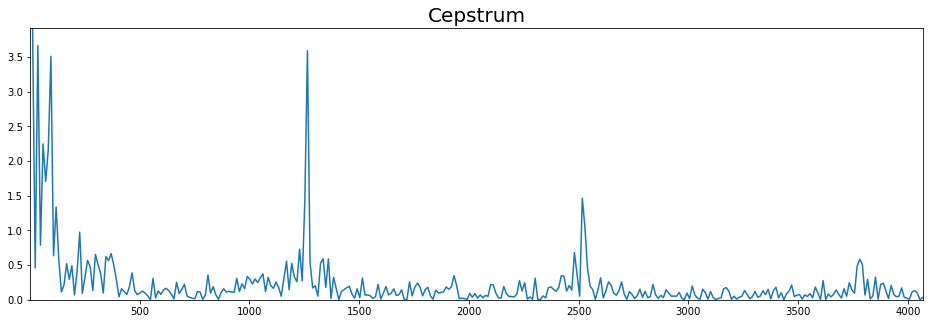

In [793]:
DCT = dct(log_power_spectrum)
ift = np.fft.ifft(log_power_spectrum)
ift = np.abs(ift)
plt.figure(figsize=(16, 5))
frequencies = np.linspace(0, sr, n_fft)
plt.plot(frequencies, ift)
plt.xlim([1, np.max(frequencies)//6])
plt.ylim([0, np.max(ift[1:])]);
plt.title("Cepstrum", fontsize=20);

<a id="data-preparation"></a>
<h1>Data Preparation</h1>

In [492]:
train_df.isnull().sum()

file_id    0
emotion    1
origin     0
dtype: int64

In [493]:
# Checking if there is a mismatch of files in the train metadata dataframe and the dataset directory
file_ids_set = set(train_df["file_id"])
audio_files_list = glob.glob(os.path.join(train_audio_path, "*.wav"))
audio_files_list = [file.replace(train_audio_path+"/", "") for file in audio_files_list]
audio_files_set = set(audio_files_list)

files_diff_file_ids = file_ids_set.difference(audio_files_set)
files_diff_audio_files = audio_files_set.difference(file_ids_set)
print("Number of file ids present in the training metadata dataframe not present in the training dataset:", len(files_diff_file_ids))
print("Number of audio file names present in the training dataset not present in the training metadata dataframe:", len(files_diff_audio_files))

Number of file ids present in the training metadata dataframe not present in the training dataset: 1
Number of audio file names present in the training dataset not present in the training metadata dataframe: 0


One file is missing a label and the training metadata dataframe contains one file id that isn't present in the training dataset. I'll find the indexes in the training metadata dataframe of these two occurrences and remove them.

In [494]:
missing_file = list(files_diff_file_ids)[0]
print("Index of instance with missing emotion:")
print(train_df[train_df.isnull().any(axis=1)].index[0])
print()
print("Index of instance with file id not present in training dataset:")
print(train_df.loc[train_df["file_id"] == missing_file].index[0])

Index of instance with missing emotion:
8937

Index of instance with file id not present in training dataset:
8937


It appears that the record with the missing label is also the instance with the file id that isn't present in the training dataset. I'll remove this record from the dataframe.

In [495]:
print("Number of instances before removal:", len(train_df.index))

train_df.drop(index=8937, inplace=True)

print("Number of instances after removal:", len(train_df.index))

Number of instances before removal: 10111
Number of instances after removal: 10110


We can see that the instance was successfully removed from the dataframe. I'll reset the indexes of the training metadata dataframe because the removed instance leaves a gap in the indexes.

In [496]:
train_df.reset_index(drop=True, inplace=True)

In [497]:
train_df.isnull().sum()

file_id    0
emotion    0
origin     0
dtype: int64

And to verify that what I did worked, I printed the counts of null values in the dataframe; it indeed worked.

I want to get the class distribution for the emotions. One way to go about doing this is simply to group the dataframe by emotion and get the counts for each emotion, but this wouldn't tell us the full story if the sound files are of varying duration, because sound files of a greater duration provide more information in training. I'll first check if the duration of files vary. If this is the case, then I will get the mean duration for each emotion and plot the distribution. The distribution is important, because if there is a substantial imbalance in the representations of emotions, the model will be biased towards those emotions that it saw more of. Thus, it will need to be addressed later on in the preprocessing phase, where I'd likely use something like data augmentation to add more instances to the underrepresented emotions.

In [246]:
# Displaying the durations of a random sample of 10 audio files.
print("Durations of a random sample of 10 audio files:")
print("-"*40)
for audio_file_name in train_df.sample(n=10)["file_id"]:
    audio_file_path = os.path.join(train_audio_path, audio_file_name)
    try:
        # Specifying None for sr uses the native sample rate of the audio file, which in this case
        # is 16kHz.
        samples, sample_rate = librosa.load(audio_file_path, sr=None)
        duration = librosa.get_duration(y=samples, sr=sample_rate)
        print("{0:.2f}s".format(duration))
    except FileNotFoundError:
        file_id = audio_file_name.replace(".wav", "")
        print(f"File with id {file_id} is missing from the training dataset.")


Durations of a random sample of 10 audio files:
----------------------------------------
2.09s
2.22s
2.07s
3.04s
1.93s
4.17s
2.37s
2.44s
2.74s
3.00s


The durations of the audio files do indeed vary. I'll append a column specifying the duration of the audio files in the training metadata dataframe so I can get the mean duration of the audio files for each emotion.

In [498]:
duration_column = pd.Series([], dtype="float64")
for audio_file_name in train_df["file_id"]:
    audio_file_path = os.path.join(train_audio_path, audio_file_name)
    try:
        samples, sample_rate = librosa.load(audio_file_path, sr=None)
        duration = librosa.get_duration(y=samples, sr=sample_rate)
        duration_column = pd.concat([duration_column, pd.Series(duration, dtype="float64")], ignore_index=True)
    except FileNotFoundError:
        file_id = audio_file_name.replace(".wav", "")
        print(f"File with id {file_id} is missing from the training dataset.")
        
duration_column = duration_column.rename("duration")
duration_column

0        2.669313
1        2.569250
2        2.902875
3        2.035375
4        2.268937
           ...   
10105    1.969649
10106    1.311911
10107    2.402720
10108    1.933972
10109    2.178873
Name: duration, Length: 10110, dtype: float64

In [499]:
# Adding durations to the training metadata dataframe
train_df = pd.concat([train_df, duration_column.rename("duration")], axis=1)

I also want to get the sample rates of each audio file and add them to the training metadata dataframe. The sampling rate is an important piece of metadata, because it dictates the size of sound files and the dimensions of the spectrograms. The problem with varying sample rates is that they result in varying dimensions, which isn't ideal for machine learning, where we want the dimensions of input data to be static. Moreover, excessively high sampling rates would result in extra unnecessary resolution, which would make training unnecessarily more computationally expensive. Thus, audio files with high sampling rates can be downsampled.

In [500]:
# Getting the sample rates of each audio file
sample_rate_column = pd.Series([], dtype="float64")
for audio_file_name in train_df["file_id"]:
    audio_file_path = os.path.join(train_audio_path, audio_file_name)
    try:
        samples, sample_rate = librosa.load(audio_file_path, sr=None)
        sample_rate_column = pd.concat([sample_rate_column, pd.Series(sample_rate, dtype="float64")], ignore_index=True)
    except FileNotFoundError:
        file_id = audio_file_name.replace(".wav", "")
        print(f"File with id {file_id} is missing from the training dataset.")
        
sample_rate_column = sample_rate_column.rename("sample_rate")

In [501]:
train_df = pd.concat([train_df, sample_rate_column], axis=1)

In [502]:
print("Sample rates used by the audio files:", ', '.join([str(round(sr))+'hz' for sr in sorted(sample_rate_column.unique())]))

Sample rates used by the audio files: 16000hz, 24414hz, 44100hz, 48000hz


It also appears that the sample rates of the sound files vary, presumably, by origin.<br>
<br>
The highest frequency speech usually reaches is about 4kHz. And, as per the <a href="https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem">Nyquist-Shannon sampling theorem</a>, the sampling rate should be double the highest frequency of a sound to be able to sufficiently capture the detail of a sound, which should be intuitive, because a sample rate double the maximum frequency is the minimum requirement to capture both the trough and peak of a cycle. Thus, in the preprocessing phase, I'll downsample the audio files with higher frequency rates to the minimum frequency rate (16kHz), and no loss of important information should occur.

I'll also get the number of audio channels for each audio file.

In [503]:
n_channels_column = pd.Series([], dtype=np.int16)
for file in train_df["file_id"].values:
    file_path = os.path.join(train_audio_path, file)
    samples, sr = librosa.load(file_path, sr=None)
    n_channels_column = pd.concat([n_channels_column, pd.Series(samples.ndim, dtype="int16")], ignore_index=True)

n_channels_column.rename("n_channels")

0        1
1        1
2        1
3        1
4        1
        ..
10105    1
10106    1
10107    1
10108    1
10109    1
Name: n_channels, Length: 10110, dtype: int16

In [504]:
n_channels_column.unique()

array([1], dtype=int16)

The training data are all monophonic, which will make pre-processing a little bit easier.

In [505]:
train_df["n_channels"] = n_channels_column

<h3>Encoding the Labels</h3>

I'll convert the labels (emotions) for each instance into a number that corresponds with the class.

In [506]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df["emotion"])
encoded_emotions = label_encoder.fit_transform(train_df["emotion"])
encoded_emotions

array([2, 2, 5, ..., 1, 3, 3])

Above, you can see what the label encoder does to the emotions: it converts them into numbers. It encodes the data in lexicographical order. <br>
<br>
I'll append the encoded classes to the training metadata dataframe.

In [507]:
train_df["encoded_emotion"] = encoded_emotions

In [508]:
# Rearranging the column order so that it's more intuitive
column_order = ["file_id", "emotion", "encoded_emotion", "origin", "duration", "sample_rate", "n_channels"]
train_df = train_df[column_order]

In [509]:
train_df.head()

file_id  emotion  encoded_emotion origin  \
0  ae2e1c07-4ad7-4bc5-bdac-d3dcf0c8673b.wav     fear                2  crema   
1  08c8ea7c-7f81-41fb-8dfa-eaff9d3c292b.wav     fear                2  crema   
2  f28d06ce-1929-40c4-8c40-7a7671d8c0ab.wav  sadness                5  crema   
3  8934caea-8409-4034-ae41-fa8552e2c3d6.wav  disgust                1  crema   
4  d53575a9-dd20-45c8-a45f-a08e2ad93b9e.wav  neutral                4  crema   

   duration  sample_rate  n_channels  
0  2.669313      16000.0           1  
1  2.569250      16000.0           1  
2  2.902875      16000.0           1  
3  2.035375      16000.0           1  
4  2.268937      16000.0           1

<h3>Saving the modified dataframe</h3>

Just so that I don't have to clean the dataframe and compute all the metadata again, I'll save the above dataframe as a different csv file in the path *./challengeA_data/* with the name *2022challengeA_train_modified.csv*.

In [511]:
train_df.to_csv("./challengeA_data/2022challengeA_train_modified.csv")

I can then load the csv file again like so:

In [512]:
train_df = pd.read_csv("./challengeA_data/2022challengeA_train_modified.csv", index_col=[0])

<h3>Emotion Distribution</h3>

I'll now get the representations of each emotion in the dataset by using the mean durations of each emotion.

In [513]:
emotion_distribution = train_df.groupby("emotion")["duration"].mean()
# Just capitalizing the labels
emotion_distribution.index = [index.capitalize() for index in emotion_distribution.index]

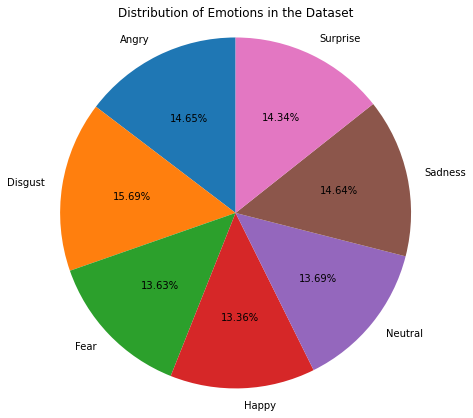

In [514]:
colors = sns.color_palette("tab10", n_colors=10)
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Distribution of Emotions in the Dataset")
ax.pie(emotion_distribution, labels=emotion_distribution.index, autopct="%.2f%%", 
       colors=colors[:len(emotion_distribution)], startangle=90)
# Set the aspect ratio to be equal so that the pie chart is drawn as a circle
ax.axis("equal");


In [486]:
train_df["emotion"].value_counts()

angry       1652
happy       1634
disgust     1629
fear        1628
sadness     1555
neutral     1452
surprise     560
Name: emotion, dtype: int64

An interesting discovery made from the above demonstration was that although the number of occurrences of surprise was roughly a 3rd of the number of occurrences of other emotions, the distribution of emotions in terms of duration was roughly uniform. Thus, there's no class imbalance to be addressed.

<a id="pre-processing"></a>
<h1>Pre-Processing</h1>

In [456]:
train_df = pd.read_csv("./challengeA_data/2022challengeA_train_modified.csv", index_col=[0])
train_df.head()

file_id  emotion  encoded_emotion origin  \
0  ae2e1c07-4ad7-4bc5-bdac-d3dcf0c8673b.wav     fear                2  crema   
1  08c8ea7c-7f81-41fb-8dfa-eaff9d3c292b.wav     fear                2  crema   
2  f28d06ce-1929-40c4-8c40-7a7671d8c0ab.wav  sadness                5  crema   
3  8934caea-8409-4034-ae41-fa8552e2c3d6.wav  disgust                1  crema   
4  d53575a9-dd20-45c8-a45f-a08e2ad93b9e.wav  neutral                4  crema   

   duration  sample_rate  n_channels  
0  2.669313      16000.0         1.0  
1  2.569250      16000.0         1.0  
2  2.902875      16000.0         1.0  
3  2.035375      16000.0         1.0  
4  2.268937      16000.0         1.0

The first thing to address is the order of data in the dataframe. As we can see, the data appears to be grouped by origin. When training a model, we want the distribution of data in each batch to be representative of the global distribution of data; thus, we should shuffle the dataframe so that we can at least be somewhat confident that the distribution of data in each batch will be similar to the global distribution.

In [462]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

file_id  emotion  encoded_emotion  \
0  56c5af5b-3c55-40cc-a4e8-cbab0838ca74.wav    happy                3   
1  7e85aaa9-63d4-498f-8693-6d064c20db52.wav    happy                3   
2  b4985a80-ba5d-4381-8984-4c80ce89b507.wav     fear                2   
3  e442e50b-7ced-406c-89e2-e6e4dcb22615.wav  neutral                4   
4  18ad05bb-2c9e-4139-9dfb-908948516113.wav  disgust                1   

    origin  duration  sample_rate  n_channels  
0    crema  1.768438      16000.0         1.0  
1     tess  1.742361      24414.0         1.0  
2  ravdess  3.403396      48000.0         1.0  
3     tess  2.780331      24414.0         1.0  
4    crema  3.870563      16000.0         1.0

Now, we must take the audio from its raw format to mel-spectrograms, such that the mel-spectrograms have equal dimensions. I'll develop a pipeline to do all of this in a neat way.

In [491]:
class Preprocessor:
    @staticmethod
    def load_audio(file):
        samples, sr = librosa.load(file, sr=16000)
        return samples, sr
    
    @staticmethod
    def get_files(path, df):
        files = []
        for file in df["file_id"]:
            file_path = os.path.join(path, file)
            files.append(file)
        return files
    
    @staticmethod
    def get_mel_spectrogram(samples, sr):
        pass
    
    def get_spectrogram():
        pass
    
    def get_mfccs(samples):
        pass

In [480]:
train_audio_files = Preprocessor.get_files(train_audio_path, train_df)
len(train_audio_files)

10111

In [ ]:
test_audio_files = Preprocessor.get_files(test_audio_path, test_df)

In [467]:
test_file = os.path.join(train_audio_path, train_df["file_id"][1])

In [468]:
test_file

'./challengeA_data/train/7e85aaa9-63d4-498f-8693-6d064c20db52.wav'

In [471]:
samples, sr = Preprocessor.load_audio(test_file)
sr

16000

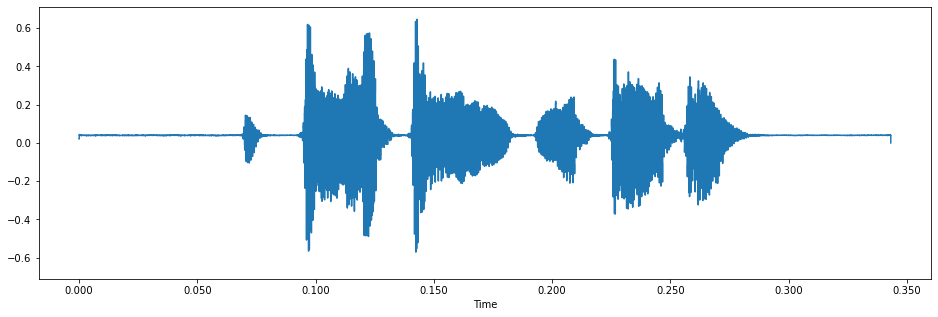

In [452]:
test_file = os.path.join(train_audio_path, train_df["file_id"][1])
preprocessor = Preprocessor()
samples, sr = preprocessor.load_audio(test_file)

plt.figure(figsize=(16, 5))
librosa.display.waveshow(samples, sr=16000);

In [ ]:
test_file = os.path.join(os.getcwd(), train_df["file_id"][0])
preprocessor.load_audio(test_file)